# Empherical Testing on PASCAL dataset

In [4]:
import mxnet as mx
import numpy as np
from mxnet import image
from mxnet.gluon.data.vision import transforms
import gluoncv
from gluoncv.data.transforms.presets.segmentation import test_transform
from gluoncv.utils.viz import get_color_pallete
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
import pandas as pd
import os
from os import path
import argparse
#import tensorflow as tf
import cv2
from skimage.measure import compare_ssim as ssim
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import jaccard_similarity_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
import scipy.io as sio
import matplotlib.image as image
import pandas as pd
import matplotlib.pyplot as plt
from mxnet import image
from mxnet.gluon.data.vision import transforms
import csv
# using cpu
ctx = mx.cpu(0)


In [5]:

class semantic_segmentation_pascal:
    def __init__(self):
        self.model=gluoncv.model_zoo.get_model('fcn_resnet101_voc', pretrained=True)

    def get_model(self):
        return self.model

In [6]:
code='pascal_segment_final'
model = semantic_segmentation_pascal().get_model()
pca = PCA(n_components=5) #2,5,7,10,13 

In [7]:
#pathe where masked images are stored before PCA
save_path='C:\\Users\\Gurpreet\\Desktop\\python\\IRTEX-Segmentation\\irtex-1.0\\segmentation\\Segmentation_CNN\\segmented_image_pascal_final\\'

def extract_features(img):
        img = test_transform(img, ctx)
        output = model.predict(img)
        predict = mx.nd.squeeze(mx.nd.argmax(output, 1)).asnumpy()
        mask = get_color_pallete(predict, 'pascal_voc')
        mask = mask.resize((128,128))
        mask_array=np.asarray(mask).flatten()

        return mask,mask_array


def segment_pascal_dataset(filename):
    feature_list = []
    # dataFile = os.getcwd()
    # print(dataFile)
    # save_path = os.path.join(dataFile, '/segmented_mask_pascal') #location to save segmented images 
    # print(save_path)

    for label in (os.listdir(filename)):
        for img_file in (os.listdir(os.path.join(filename, label))):
        
            img = image.imread(os.path.join(filename,label,img_file))   #<class 'mxnet.ndarray.ndarray.NDArray'>
            mask , mask_array = extract_features(img)
            name,extension=path.splitext(img_file)
            mask.save(save_path+name+'.png')

            ########## PCA ############
            mask = np.resize(mask,(128,128))
            mask = np.array(mask)
            mask_norm = normalize(mask)
            mask_pca = pca.fit_transform(mask_norm)
            
            segmented_img_pca=mask_pca.flatten() #1d array for the segmented image

            row = [img_file,segmented_img_pca,label]
            feature_list.append(row)
            # print(feature_list)
            # break
        
    df = pd.DataFrame(feature_list, columns=["file_name", code ,"label"])
    pd.to_pickle(df, code+'.pkl')



# Similarity Computation after Dimensionality Reduction with PCA

In [91]:

def similarity_images_pca(mask_query_img ):
    count=0
    n_components=2
    pca = PCA(n_components=n_components)   #2 5 7 10 13
    similarity=[]
    mask_query_img = np.array(mask_query_img)
    mask_query_img_norm = normalize(mask_query_img)
    mask_query_img = pca.fit_transform(mask_query_img_norm)
    mask_query_img  =mask_query_img.flatten()

    for img_file in tqdm(os.listdir(save_path)):
        img = image.imread(os.path.join(save_path,img_file))
        img = img.reshape((128,128))        
        img = img.asnumpy()
        
        img_norm = normalize(img)
        img = pca.fit_transform(img_norm)
        img=img.flatten()
        
        #print(mask_query_img.shape,type(mask_query_img),img.shape ,(type(img)))
        sim_ssim = ssim(mask_query_img.reshape(128,n_components), img.reshape(128,n_components),multichannel=True)
        sim_ari = adjusted_rand_score(mask_query_img.flatten(),img.flatten())
        
        #print (np.array(mask_query_img).shape, np.array(img).shape)
        
        #sim_jaccard = jaccard_similarity_score(np.array(mask_query_img).ravel(),np.array(img).ravel())
        row=[img_file,sim_ari,sim_ssim]
        similarity.append(row)
        
#         count=count+1
#         if(count==2000):
#             break
    
    return similarity

In [25]:
query_path='C:\\Users\\Gurpreet\\Desktop\\python\\IRTEX-Segmentation\\VOCdevkit\\VOC2012\\JPEGImages\\2011_004537.jpg'
img = image.imread(query_path) 
print(type(img))
segmented_mask_query_img , predict_flat_query_img = extract_features(img) 

<class 'mxnet.ndarray.ndarray.NDArray'>


In [ ]:
similarity_pca=similarity_images_pca(segmented_mask_query_img)

In [93]:
import csv

path='C:\\Users\\Gurpreet\\Desktop\\python\\IRTEX-Segmentation\\pascal_labels.csv'
ari_pca=[]
ssim_pca=[]
    
for i in range(len(similarity_pca)):
    filename,extension = similarity_pca[i][0].split('.')
    ari_val= similarity_pca[i][1]
    ssim_val = similarity_pca[i][2]
    count=0
    labels=[]
    with open(path) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            if(count==0):
                count=count+1
            else:
                name,ext = row[0].split('.')
                if(filename==name):
                    labels.append(row[1])
                    
        entry_ari=[filename+'.jpg',ari_val,labels]
        entry_ssim=[filename+'.jpg',ssim_val,labels]
    ari_pca.append(entry_ari)
    ssim_pca.append(entry_ssim)

In [94]:
ari_pca = sorted(ari_pca , key=lambda ari:ari[1] ,reverse=True)
ssim_pca = sorted(ssim_pca , key=lambda ssim:ssim[1] ,reverse=True)

In [95]:
#label_query
path='C:\\Users\\Gurpreet\\Desktop\\python\\IRTEX-Segmentation\\pascal_labels.csv'
query_file_name= '2007_000027.jpg'
query_labels=[]
with open(path) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            if(count==0):
                count=count+1
            else:
                if(query_file_name==row[0]):
                    query_labels.append(row[1])


In [96]:
top_k=[100,200,300,400,500]

precision_score_ari_pca=[]
precision_score_ssim_pca=[]

recall_score_ari_pca=[]
recall_score_ssim_pca=[]

f1_score_ari_pca=[]
f1_score_ssim_pca=[]


rel_ari_pca=0
rel_ssim_pca=0

for i in range(len(ari_pca)):
    query_labels=set(query_labels)
    labels_ari=set(ari_pca[i][2])
    labels_ssim=set(ssim_pca[i][2])
    if(len(query_labels.intersection(labels_ari))>0):
            rel_ari_pca=rel_ari_pca+1
    if(len(query_labels.intersection(labels_ssim))>0):
            rel_ssim_pca=rel_ssim_pca+1

print(rel_ari_pca, rel_ssim_pca)
            
for i in top_k:
    rel_ret_ari_pca=0
    rel_ret_ssim_pca=0
    for j in range(i):
        query_labels=set(query_labels)
        labels_ari=set(ari_pca[j][2])
        labels_ssim=set(ssim_pca[j][2])
        if(len(query_labels.intersection(labels_ari))>0):
            rel_ret_ari_pca = rel_ret_ari_pca + 1
        if(len(query_labels.intersection(labels_ssim))>0):
            rel_ret_ssim_pca = rel_ret_ssim_pca + 1
            
    print(rel_ret_ari_pca,rel_ret_ssim_pca)
    
    precision_ari_pca = rel_ret_ari_pca/i
    precision_ssim_pca = rel_ret_ssim_pca/i
    
    recall_ari_pca = rel_ret_ari_pca/rel_ari_pca
    recall_ssim_pca = rel_ret_ari_pca/rel_ssim_pca
    
    f1_ari_pca = ((2*precision_ari_pca * recall_ari_pca)/(precision_ari_pca + recall_ari_pca))
    f1_ssim_pca = ((2*precision_ssim_pca * recall_ssim_pca)/(precision_ssim_pca + recall_ssim_pca))
    
    precision_score_ari_pca.append(precision_ari_pca)
    precision_score_ssim_pca.append(precision_ssim_pca)
    
    recall_score_ari_pca.append(recall_ari_pca)
    recall_score_ssim_pca.append(recall_ssim_pca)
    
    f1_score_ari_pca.append(f1_ari_pca)
    f1_score_ssim_pca.append(f1_ssim_pca)
    
    
print("precision",precision_score_ari_pca,precision_score_ssim_pca)
print("recall",recall_score_ari_pca,recall_score_ssim_pca)
print("f1score",f1_score_ari_pca,f1_score_ssim_pca)

1184 1184
49 60
105 116
158 182
213 213
267 249
precision [0.49, 0.525, 0.5266666666666666, 0.5325, 0.534] [0.6, 0.58, 0.6066666666666667, 0.5325, 0.498]
recall [0.041385135135135136, 0.08868243243243243, 0.13344594594594594, 0.17989864864864866, 0.22550675675675674] [0.041385135135135136, 0.08868243243243243, 0.13344594594594594, 0.17989864864864866, 0.22550675675675674]
f1score [0.07632398753894082, 0.15173410404624277, 0.21293800539083557, 0.2689393939393939, 0.31710213776722085] [0.07742954964445616, 0.15384226746829685, 0.21876997048172606, 0.2689393939393939, 0.3104390216569075]


### Precision / Recall / F1-score for PCA componenets 2/5/7/10/13

In [16]:
precision_score_ari_pca_2 , precision_score_ssim_pca_2 = precision_score_ari_pca , precision_score_ssim_pca
recall_score_ari_pca_2 , recall_score_ssim_pca_2 = recall_score_ari_pca , recall_score_ssim_pca
f1_score_ari_pca_2 , f1_score_ssim_pca_2 = f1_score_ari_pca , f1_score_ssim_pca

In [23]:
precision_score_ari_pca_5 , precision_score_ssim_pca_5 = precision_score_ari_pca , precision_score_ssim_pca
recall_score_ari_pca_5 , recall_score_ssim_pca_5 = recall_score_ari_pca , recall_score_ssim_pca
f1_score_ari_pca_5 , f1_score_ssim_pca_5 = f1_score_ari_pca , f1_score_ssim_pca

In [71]:
precision_score_ari_pca_7 , precision_score_ssim_pca_7 = precision_score_ari_pca , precision_score_ssim_pca
recall_score_ari_pca_7 , recall_score_ssim_pca_7 = recall_score_ari_pca , recall_score_ssim_pca
f1_score_ari_pca_7 , f1_score_ssim_pca_7 = f1_score_ari_pca , f1_score_ssim_pca

In [38]:
precision_score_ari_pca_10 , precision_score_ssim_pca_10 = precision_score_ari_pca , precision_score_ssim_pca
recall_score_ari_pca_10 , recall_score_ssim_pca_10 = recall_score_ari_pca , recall_score_ssim_pca
f1_score_ari_pca_10 , f1_score_ssim_pca_10 = f1_score_ari_pca , f1_score_ssim_pca

In [45]:
precision_score_ari_pca_13 , precision_score_ssim_pca_13 = precision_score_ari_pca , precision_score_ssim_pca
recall_score_ari_pca_13 , recall_score_ssim_pca_13 = recall_score_ari_pca , recall_score_ssim_pca
f1_score_ari_pca_13 , f1_score_ssim_pca_13 = f1_score_ari_pca , f1_score_ssim_pca

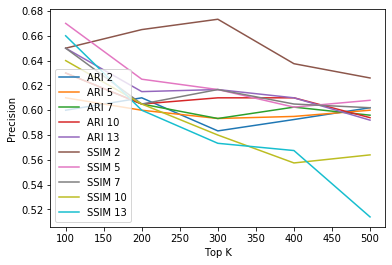

In [46]:
plt.figure("Precision_PCA")
plt.xlabel('Top K')
plt.ylabel('Precision')
plt.plot(top_k, precision_score_ari_pca_2)
plt.plot(top_k, precision_score_ari_pca_5)
plt.plot(top_k, precision_score_ari_pca_7)
plt.plot(top_k, precision_score_ari_pca_10)
plt.plot(top_k, precision_score_ari_pca_13)

plt.plot(top_k, precision_score_ssim_pca_2)
plt.plot(top_k, precision_score_ssim_pca_5)
plt.plot(top_k, precision_score_ssim_pca_7)
plt.plot(top_k, precision_score_ssim_pca_10)
plt.plot(top_k, precision_score_ssim_pca_13)

plt.legend(["ARI 2", "ARI 5","ARI 7","ARI 10" , "ARI 13" , "SSIM 2" , "SSIM 5" ,"SSIM 7","SSIM 10" , "SSIM 13"])

plt.show()




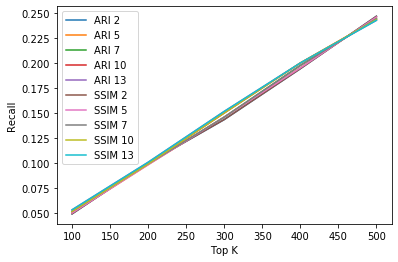

In [47]:


plt.figure("Recall_PCA")
plt.xlabel('Top K')
plt.ylabel('Recall')
plt.plot(top_k, recall_score_ari_pca_2)
plt.plot(top_k, recall_score_ari_pca_5)
plt.plot(top_k, recall_score_ari_pca_7)
plt.plot(top_k, recall_score_ari_pca_10)
plt.plot(top_k, recall_score_ari_pca_13)

plt.plot(top_k, recall_score_ssim_pca_2)
plt.plot(top_k, recall_score_ssim_pca_5)
plt.plot(top_k, recall_score_ssim_pca_7)
plt.plot(top_k, recall_score_ssim_pca_10)
plt.plot(top_k, recall_score_ssim_pca_13)

plt.legend(["ARI 2", "ARI 5","ARI 7","ARI 10" , "ARI 13" , "SSIM 2" , "SSIM 5" ,"SSIM 7","SSIM 10" , "SSIM 13"])

plt.show()



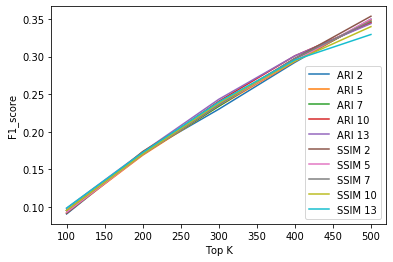

In [48]:
plt.figure("F1 Score PCA")
plt.xlabel('Top K')
plt.ylabel('F1_score')
plt.plot(top_k, f1_score_ari_pca_2)
plt.plot(top_k, f1_score_ari_pca_5)
plt.plot(top_k, f1_score_ari_pca_7)
plt.plot(top_k, f1_score_ari_pca_10)
plt.plot(top_k, f1_score_ari_pca_13)

plt.plot(top_k, f1_score_ssim_pca_2)
plt.plot(top_k, f1_score_ssim_pca_5)
plt.plot(top_k, f1_score_ssim_pca_7)
plt.plot(top_k, f1_score_ssim_pca_10)
plt.plot(top_k, f1_score_ssim_pca_13)


plt.legend(["ARI 2", "ARI 5","ARI 7","ARI 10" , "ARI 13" , "SSIM 2" , "SSIM 5" ,"SSIM 7","SSIM 10" , "SSIM 13"])

plt.show()

# Testing system performance with query image, taken from outside of selected dataset subset

In [ ]:
query_path='C:\\Users\\Gurpreet\\Desktop\\python\\IRTEX-Segmentation\\VOCdevkit\\VOC2012\\JPEGImages\\2007_000027.jpg'
img = image.imread(query_path) 
print(type(img))
segmented_mask_query_img , predict_flat_query_img = extract_features(img) 

similarity_pca=similarity_images_pca(segmented_mask_query_img)

In [ ]:
similarity_pca=similarity_images_pca(segmented_mask_query_img)

In [97]:
precision_score_ari_pca_2 , precision_score_ssim_pca_2 = precision_score_ari_pca , precision_score_ssim_pca
recall_score_ari_pca_2 , recall_score_ssim_pca_2 = recall_score_ari_pca , recall_score_ssim_pca
f1_score_ari_pca_2 , f1_score_ssim_pca_2 = f1_score_ari_pca , f1_score_ssim_pca

In [90]:
precision_score_ari_pca_5 , precision_score_ssim_pca_5 = precision_score_ari_pca , precision_score_ssim_pca
recall_score_ari_pca_5 , recall_score_ssim_pca_5 = recall_score_ari_pca , recall_score_ssim_pca
f1_score_ari_pca_5 , f1_score_ssim_pca_5 = f1_score_ari_pca , f1_score_ssim_pca

In [72]:
precision_score_ari_pca_7 , precision_score_ssim_pca_7 = precision_score_ari_pca , precision_score_ssim_pca
recall_score_ari_pca_7 , recall_score_ssim_pca_7 = recall_score_ari_pca , recall_score_ssim_pca
f1_score_ari_pca_7 , f1_score_ssim_pca_7 = f1_score_ari_pca , f1_score_ssim_pca

In [64]:
precision_score_ari_pca_10 , precision_score_ssim_pca_10 = precision_score_ari_pca , precision_score_ssim_pca
recall_score_ari_pca_10 , recall_score_ssim_pca_10 = recall_score_ari_pca , recall_score_ssim_pca
f1_score_ari_pca_10 , f1_score_ssim_pca_10 = f1_score_ari_pca , f1_score_ssim_pca

In [57]:
precision_score_ari_pca_13 , precision_score_ssim_pca_13 = precision_score_ari_pca , precision_score_ssim_pca
recall_score_ari_pca_13 , recall_score_ssim_pca_13 = recall_score_ari_pca , recall_score_ssim_pca
f1_score_ari_pca_13 , f1_score_ssim_pca_13 = f1_score_ari_pca , f1_score_ssim_pca

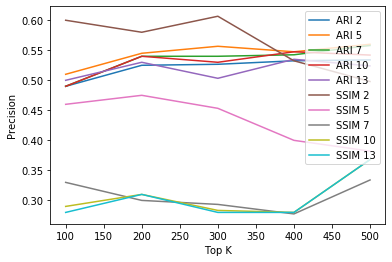

In [101]:
plt.figure("Precision_PCA")
plt.xlabel('Top K')
plt.ylabel('Precision')
plt.plot(top_k, precision_score_ari_pca_2)
plt.plot(top_k, precision_score_ari_pca_5)
plt.plot(top_k, precision_score_ari_pca_7)
plt.plot(top_k, precision_score_ari_pca_10)
plt.plot(top_k, precision_score_ari_pca_13)

plt.plot(top_k, precision_score_ssim_pca_2)
plt.plot(top_k, precision_score_ssim_pca_5)
plt.plot(top_k, precision_score_ssim_pca_7)
plt.plot(top_k, precision_score_ssim_pca_10)
plt.plot(top_k, precision_score_ssim_pca_13)

plt.legend(["ARI 2", "ARI 5","ARI 7","ARI 10" , "ARI 13" , "SSIM 2" , "SSIM 5" ,"SSIM 7","SSIM 10" , "SSIM 13"],loc=1)

plt.show()


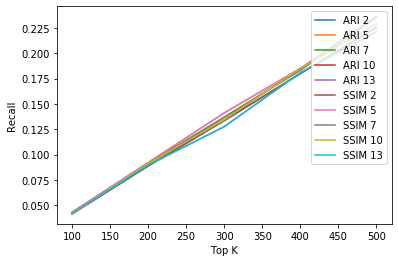

In [102]:


plt.figure("Recall_PCA")
plt.xlabel('Top K')
plt.ylabel('Recall')
plt.plot(top_k, recall_score_ari_pca_2)
plt.plot(top_k, recall_score_ari_pca_5)
plt.plot(top_k, recall_score_ari_pca_7)
plt.plot(top_k, recall_score_ari_pca_10)
plt.plot(top_k, recall_score_ari_pca_13)

plt.plot(top_k, recall_score_ssim_pca_2)
plt.plot(top_k, recall_score_ssim_pca_5)
plt.plot(top_k, recall_score_ssim_pca_7)
plt.plot(top_k, recall_score_ssim_pca_10)
plt.plot(top_k, recall_score_ssim_pca_13)

plt.legend(["ARI 2", "ARI 5","ARI 7","ARI 10" , "ARI 13" , "SSIM 2" , "SSIM 5" ,"SSIM 7","SSIM 10" , "SSIM 13"],loc=1)

plt.show()



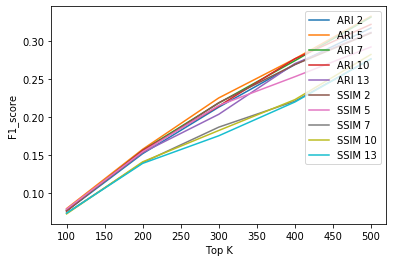

In [103]:
plt.figure("F1 Score PCA")
plt.xlabel('Top K')
plt.ylabel('F1_score')
plt.plot(top_k, f1_score_ari_pca_2)
plt.plot(top_k, f1_score_ari_pca_5)
plt.plot(top_k, f1_score_ari_pca_7)
plt.plot(top_k, f1_score_ari_pca_10)
plt.plot(top_k, f1_score_ari_pca_13)

plt.plot(top_k, f1_score_ssim_pca_2)
plt.plot(top_k, f1_score_ssim_pca_5)
plt.plot(top_k, f1_score_ssim_pca_7)
plt.plot(top_k, f1_score_ssim_pca_10)
plt.plot(top_k, f1_score_ssim_pca_13)


plt.legend(["ARI 2", "ARI 5","ARI 7","ARI 10" , "ARI 13" , "SSIM 2" , "SSIM 5" ,"SSIM 7","SSIM 10" , "SSIM 13"],loc=1)

plt.show()